### Importing necessary libraries

In [332]:
import os
import argparse
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from YAD2K.yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body
import imageio

%matplotlib inline

### Aim of the Project

Build a self-driving car system. As a first critical component first we'll build a car detection system.

We have 80 classes that we want the YOLO to recognize, we can represent the class label as c either as an integer from 1-80, or as an 80-Dimensional vector(with 80 numbers) one component of which is 1 & rest of which are 0.

Note: We'll analyze how YOLO works and then apply it to car detection. We'll use pretrained weights because the YOLO model is very computationally expensive to train.

### YOLO

YOLO (You only look once) is a popular algorithm because it gives a higher accuracy while being able run in real time.
"Only looks once" means that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

* The **input** is a batch of images of shape (m,608,608,3)
* The **output** is a list of bounding boxes along with the recognized classess. Each bounding box is represented by 6 numbers (𝑝𝑐,𝑏𝑥,𝑏𝑦,𝑏ℎ,𝑏𝑤,𝑐). If we expand c is into 80 numbers(classes) then each bounding box is represented by 85 numbers.

We will use 5 anchor boxes.
The YOLO architecture will be as the following: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85)/.

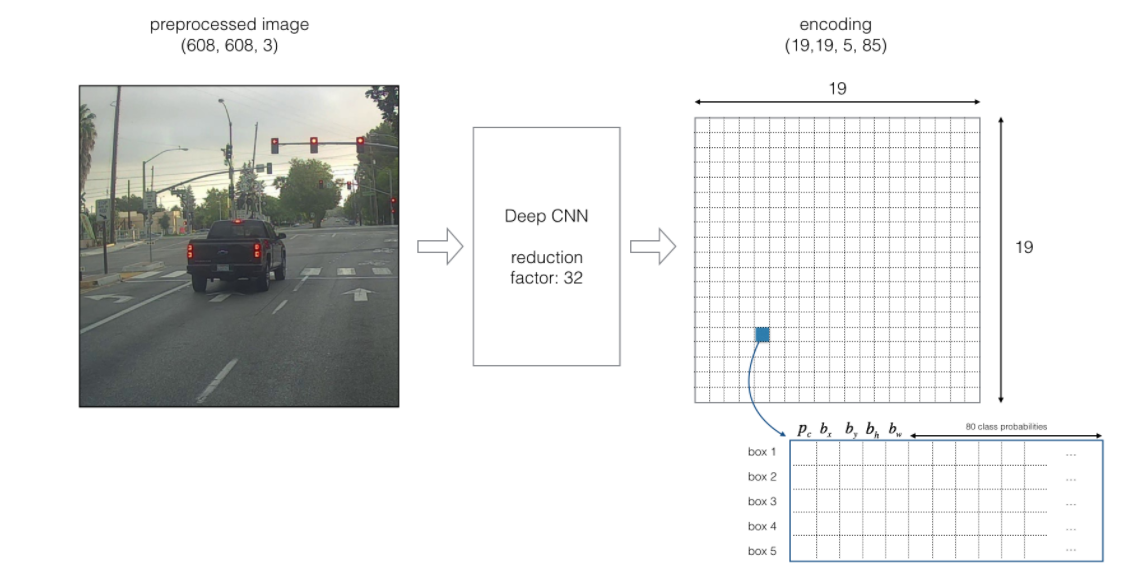

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since we are using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).

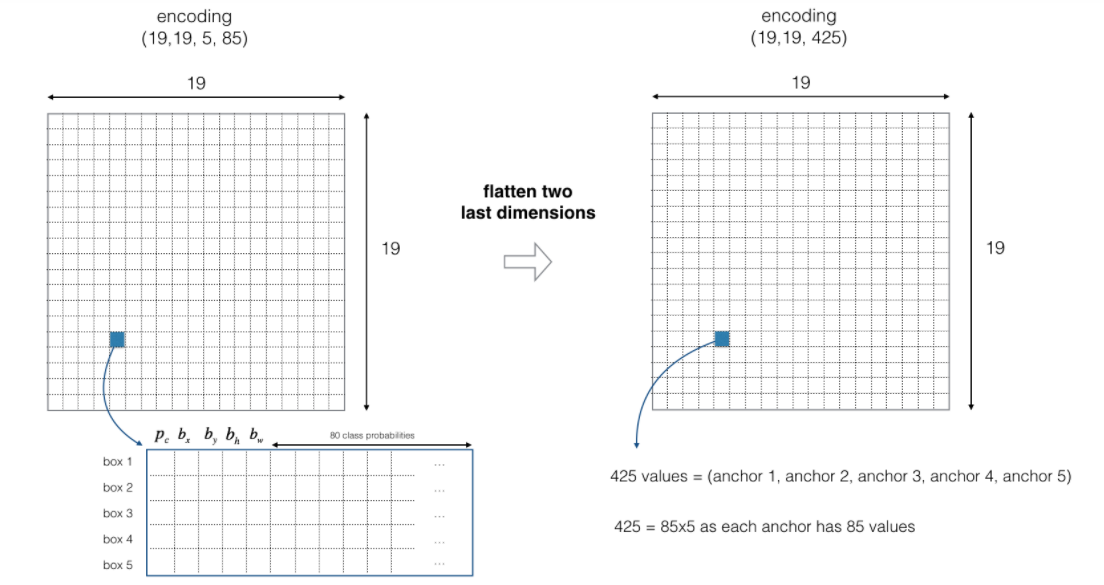

Now, for each box (of each cell) we will compute the following elementwise product and extract a probability that the box contains a certain class.

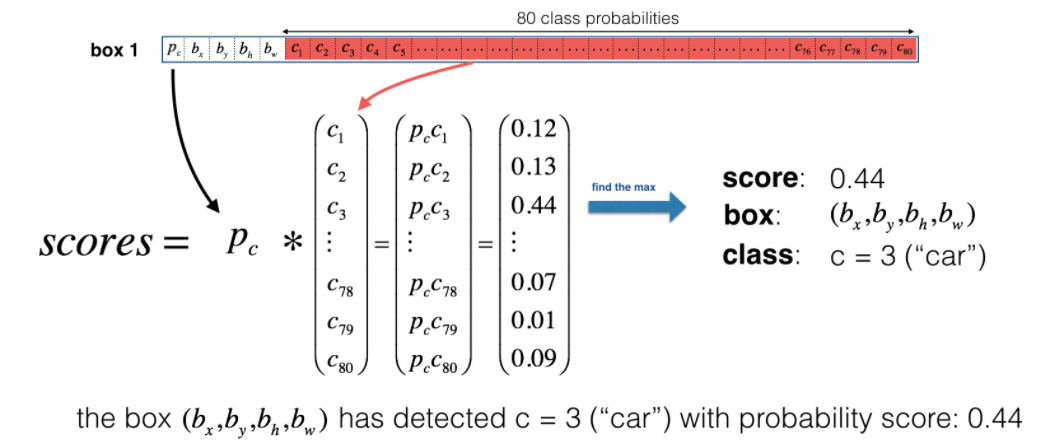

Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:
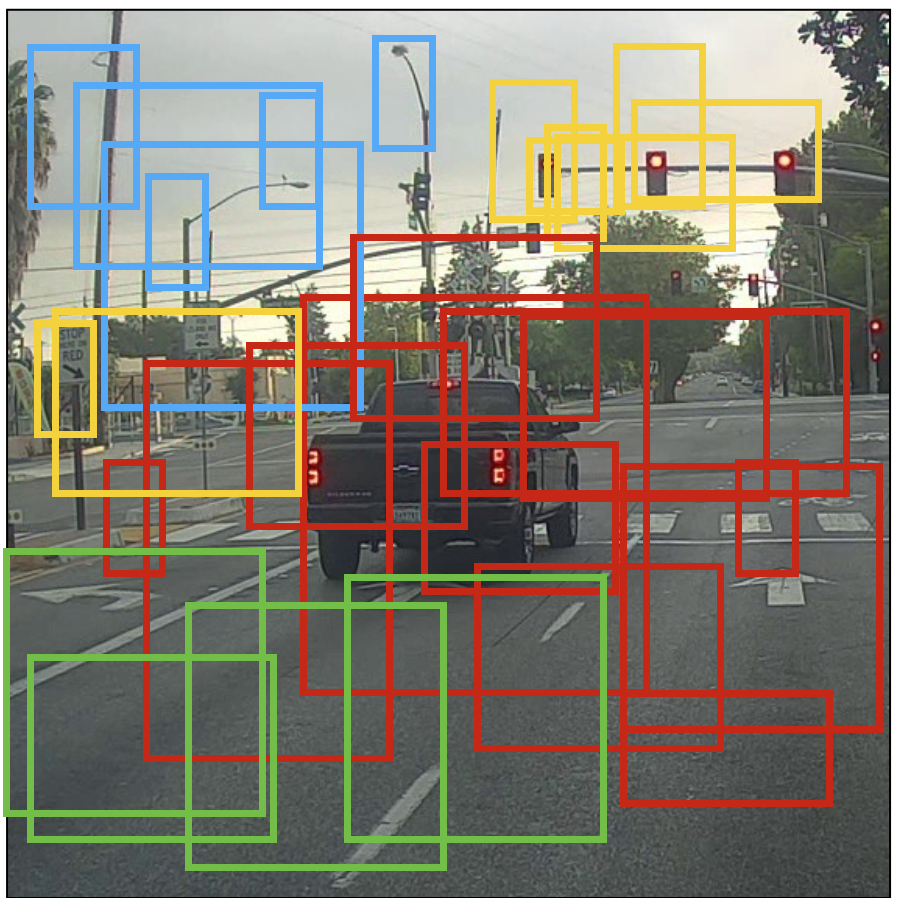

**Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes.**

In the figure above, we plotted only boxes that the model had assigned a high probability to, but this is still too many boxes. You'd like to filter the algorithm's output down to a much smaller number of detected objects. To do so, you'll use non-max suppression. Specifically, you'll carry out these steps:

* Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class)
* Select only one box when several boxes overlap with each other and detect the same object.

### Filtering with a threshold on class scores

We would get rid of any box for which the class "score" is less than a chosen threshold.

The model gives us a total of 19x19x5x85 numbers, with each box described by 85 numbers. We will arrange (19x19x5x85) to (19x19x425) for simplicity.
* box_confidence: tensor of shape  (19×19,5,1)  containing  𝑝𝑐  (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
* boxes: tensor of shape  (19×19,5,4)  containing  (𝑏𝑥,𝑏𝑦,𝑏ℎ,𝑏𝑤)  for each of the 5 boxes per cell.
* box_class_probs: tensor of shape  (19×19,5,80)  containing the detection probabilities  (𝑐1,𝑐2,...𝑐80)  for each of the 80 classes for each of the 5 boxes per cell.

**Implement yolo_filter_boxes() function**
1. Compute box scores by doing the element-wise product
    
    a = np.random.randn(19x19, 5, 1)
    
    b = np.random.randn(19x19, 5, 80)
    
    c = a x b # shape will be (19x19, 5, 80)
    
    
2. For each box, find:
    * The index of the class the maximum box score
    * The corresponding box score

3. Create a mask by using a threshold. As a reminder: ([0.9, 0.3, 0.4, 0.5, 0.1] < 0.4) returns: [False, True, False, False, True]. The mask should be True for the boxes you want to keep.

4. Use TensorFlow to apply the mask to box_class_scores, boxes and box_classes to filter out the boxes we don't want. You should be left with just the subset of boxes you want to keep.

In [303]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=0.6):
    
    '''
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4) containing (b_x, b_y, b_h, b_w)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    '''
    
    box_scores = box_confidence * box_class_probs #shape(19x19, 5, 80)
    
    box_classes = K.argmax(box_scores, axis=-1) #index of the class with max box score. shape(19x19, 5, 1)
    box_class_scores = K.max(box_scores, axis=-1) #corresponding box score. shape(19x19, 5, 1)
    
    filtering_mask = box_class_scores >= threshold #shape(19x19, 5, 1) same dimension as box_class_scores
    
    scores = tf.boolean_mask(box_class_scores, filtering_mask, name='boolean_mask')
    boxes = tf.boolean_mask(boxes, filtering_mask, name='boolean_mask')
    classes = tf.boolean_mask(box_classes, filtering_mask, name='boolean_mask')
    
    return scores, boxes, classes

In [304]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))
    print(len(scores.eval()))

scores[2] = 10.750582
boxes[2] = [ 8.426533   3.2713668 -0.5313436 -4.9413733]
classes[2] = 7
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)
1783


**Result: Now for the whole image we have only the box_class_scores above the threshold value as in "scores", respective boxes as in "boxes" & the classified class for each box as in "classes".**

**From the whole picture we have selected 1783 boxes**

### Non-max suppression

Even after filtering by threshold we can still end up alot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS).

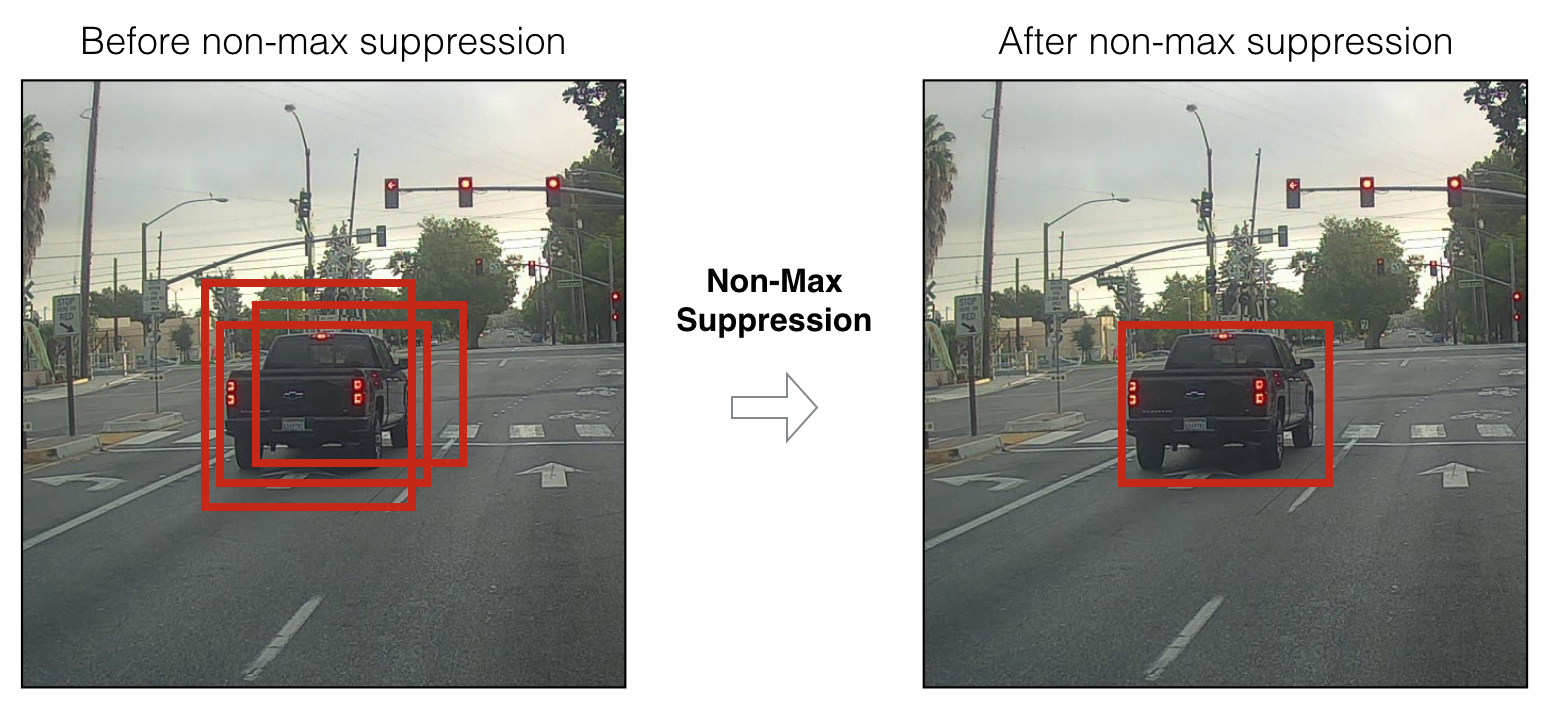

In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probabiliy) one of the 3 boxes.

Non-max suppression uses IoU (Intersection over Union) concept

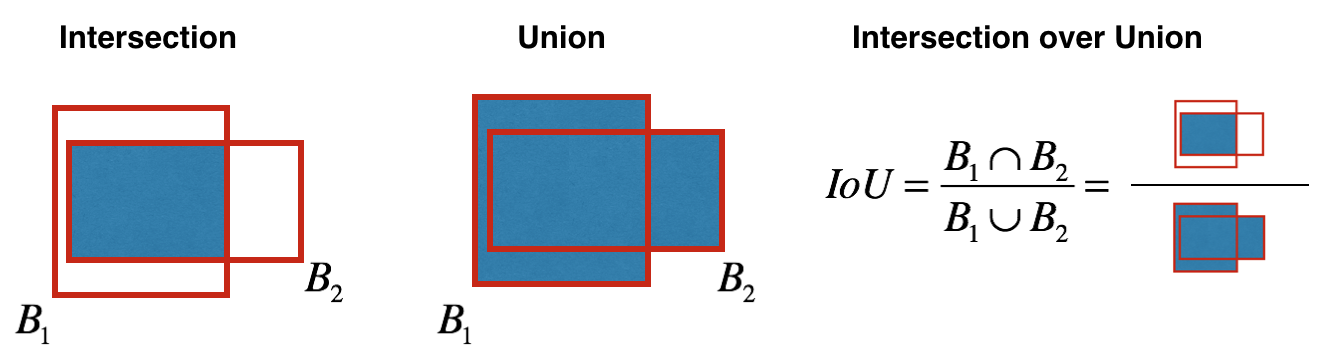

**Each Box is defined by using its two corners(upper left and lower right): (x1, y1, x2, y2)**

To calculate the area of the rectangles we'll multiply (x2-x1)*(y2-y1)

**The coordinates of the intersection of the 2 boxes are (xi1, yi1, xi2, yi2)**

Note: 
    - xi1 = maximum of the x1 coordinates of the two boxes
    - yi1 = maximum of the y1 coordinates of the two boxes
    - xi2 = minimum of the x2 coordinates of the two boxes
    - yi2 = minimum of the y2 coordinates of the two boxes
    
    In order to compute the intersection area, you need to make sure the height and width of the intersection are positive, otherwise the intersection area should be zero. Use max(height, 0) and max(width, 0).

In [305]:
def iou(box1, box2):
    
    # box1: (x1, y1, x2, y2)
    # box2: (x1, y1, x2, y2)
    
    xi1 = np.max([box1[0], box2[0]])
    yi1 = np.max([box1[1], box2[1]])
    xi2 = np.min([box1[2], box2[2]])
    yi2 = np.min([box1[3], box2[3]])
    inter_area = max(yi2-yi1, 0) * max(xi2-xi1, 0)
    
    
    box1_area = (box1[3] - box1[1]) * (box1[2] - box1[0])
    box2_area = (box2[3] - box2[1]) * (box2[2] - box2[0])    
    union_area = box1_area + box2_area - inter_area
    
    
    iou = inter_area / union_area
    
    return iou

In [306]:
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou = " + str(iou(box1, box2)))

iou = 0.14285714285714285


The key steps to implement non-max suppression:
    - Select the box that has the highest score.
    - Compute its overlap with all other boxes, and remove boxes that overlap it more than iou_threshold.
    - Go back to step 1 and iterate until there's no more boxes with a lower score than the current selected box.

In [307]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes=10, iou_threshold=0.5):
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32') # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # To get list of indices corresponding to the boxes that we keep, we use tf.image.non_max_suppression
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold=0.5)
    
    # To get only nms_indices from scores, boxes, & classes we use K.gather
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [308]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))
    print(len(scores.eval()))

scores[2] = 6.938395
boxes[2] = [-5.299932    3.1379814   4.450367    0.95942086]
classes[2] = -2.2452729
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)
10


**Result: Out of the boxes selected in threshold classification we have further reduced the number of boxes(by removing all the overlapping boxes) with the help of Non-max suppression.**

**From the whole picture we have selected 10 boxes.**

### Combining all filtering in single function

Note: boxes = scale_boxes(boxes, image_shape)

YOLO's network was trained to run on 608x608 images. If you are testing this data on a different size image--for example, the car detection dataset had 720x1280 images--this step rescales the boxes so that they can be plotted on top of the original 720x1280 image.

In [309]:
def yolo_eval(yolo_outputs, image_shape=(720., 1280.), max_boxes=10, score_threshold=0.6, iou_threshold=0.5):
    
    # Retrieving outputs of the YOLO model
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    
    # Converting boxes from x,y,h,w coordinates to corner coordinates ie.left-top & right-lowest (x1,y1,x2,y2)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)
    
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes=10, iou_threshold=0.5)
    
    return scores, boxes, classes

In [310]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


### Summary for YOLO:


Input image: (608, 608, 3)

The input image goes through CNN, resulting in a (19, 19, 5, 85) dimensional output/encoding.

   - Here we have 5 number of Anchor boxes for each cell of the 19x19 image, &
   - For the number 85 we have
     * pc - probability of finding an object
     * 80 classes
     * 4 dimensions of the box (bx,by,bh,bw)

We then select few boxes (1728 in above example) out of the total boxes (ie. 19x19x5) based on 'Score-thresholding' approach.

Then we discard the overlapping boxes with Non-Max Suppression (which basically uses IoU concept). And finally get max of 10 boxes in the image.

### YOLO pretrained Model on Images

Now we will use a pretrained model and test it to a car detection dataset.

In [311]:
tf.global_variables_initializer()

<tf.Operation 'init_76' type=NoOp>

In [312]:
sess = K.get_session() # creating a session

#### Defining classes, anchors and image shape

We have gathered the information about the 80 classes and 5 boxes in two files "coco_classes.txt" and "yolo_anchors.txt".
Lets load these quantities into the model.

The car detection dataset has 720x1280 images, which we have pre-processed into 608x608 images

In [313]:
class_names = read_classes("yad2k/model_data/coco_classes.txt")
anchors = read_anchors('yad2k/model_data/yolo_anchors.txt')
image_shape = (720., 1280.)

#### Loading a pretrained model

Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounded boxes for a large range of target datasets.

We will load an existing pretrained Keras YOLO model stored in "yolo.h5". (These weights come from the official YOLO website)

In [314]:
yolo_model = load_model("yolo.h5") # Loads the weights of a trained YOLO model

In [316]:
yolo_model.summary()
# This model converts a preprocessed batch of input images (shape: (m, 608, 608, 3)) into a tensor of shape (m, 19, 19, 5, 85)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

### Convert output of the model to usable bounding box tensors

The output of yolo_model is a (m,19,19,5,85) tensor that needs to pass through non-trivial processing and conversion.

In [317]:
yolo_model.output

<tf.Tensor 'conv2d_23_6/BiasAdd:0' shape=(?, 19, 19, 425) dtype=float32>

In [318]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [319]:
yolo_outputs

(<tf.Tensor 'truediv_86:0' shape=(?, ?, ?, 5, 2) dtype=float32>,
 <tf.Tensor 'truediv_87:0' shape=(?, ?, ?, 5, 2) dtype=float32>,
 <tf.Tensor 'Sigmoid_27:0' shape=(?, ?, ?, 5, 1) dtype=float32>,
 <tf.Tensor 'Softmax_13:0' shape=(?, ?, ?, 5, 80) dtype=float32>)

In [320]:
yolo_outputs1
yolo_outputs1[0]=yolo_outputs[2]
yolo_outputs1[1]=yolo_outputs[0]
yolo_outputs1[2]=yolo_outputs[1]
yolo_outputs1[3]=yolo_outputs[3]
yolo_outputs1

[<tf.Tensor 'Sigmoid_27:0' shape=(?, ?, ?, 5, 1) dtype=float32>,
 <tf.Tensor 'truediv_86:0' shape=(?, ?, ?, 5, 2) dtype=float32>,
 <tf.Tensor 'truediv_87:0' shape=(?, ?, ?, 5, 2) dtype=float32>,
 <tf.Tensor 'Softmax_13:0' shape=(?, ?, ?, 5, 80) dtype=float32>]

We added `yolo_outputs` to our graph. This set of 4 tensors is ready to be used as input by our yolo_eval function.

### Filtering boxes

`yolo_output` gave us all the predicted boxes of `yolo_model` in correct format. We're now ready to perform filtering and select only the best boxes.

In [321]:
scores, boxes, classes = yolo_eval(yolo_outputs1, image_shape)

### Run the graph on an image

We have created a `sess` graph that can be summarised as follows:
    1. yolo_model.input is given to `yolo_model`. The model is used to compute the output yolo_model.output
    2. yolo_model.output is processed by `yolo_head`. It gives you yolo_outputs
    3. yolo_outputs goes through a filtering function, `yolo_eval`. It outputs your predictions: scores, boxes & classes

Now we will implement a function `predict()` which runs the graph to test YOLO on an image. We will need to run a TensorFlow session, to have it compute scores, boxes and classes.

We will also use the following function:

    - image, image_data = preprocess_image("images/" + image_file, model_image_size = (608,608))
    
which outputs:
    * image: a python (PIL) representation of your image used for drawing boxes.
    * image_data: a numpy-array representing the image. This will be the input to the CNN.

**Important note**: when a model uses BatchNorm (as is the case in YOLO), you will need to pass an additional placeholder in the feed_dict {K.learning_phase(): 0}.

In [341]:
def predict(sess, image_file):
     
    # This function runs the graph stored in "sess" to predict boxes for "image_file". Prints the plot and predictions
    
    # Preprocess the image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))    
    
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict = {yolo_model.input: image_data, K.learning_phase(): 0})
    
    # Print the predictions info
    print('Found {} boxes for {}'. format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes
    colors = generate_colors(class_names)
    # Draw bounding boxes on image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    output_image=imageio.imread(os.path.join("out", image_file))
    imshow(output_image)
    plt.show()
    
    return out_scores, out_boxes, out_classes

Test the function on "test.jpg" image

Found 0 boxes for 0001.jpg
Found 0 boxes for 0002.jpg
Found 3 boxes for 0003.jpg
car 0.69 (347, 289) (445, 321)
car 0.70 (230, 307) (317, 354)
car 0.73 (671, 284) (770, 315)
Found 4 boxes for 0004.jpg
car 0.63 (400, 285) (515, 327)
car 0.66 (95, 297) (227, 342)
car 0.68 (1, 321) (121, 410)
car 0.72 (539, 277) (658, 318)
Found 5 boxes for 0005.jpg
car 0.64 (207, 297) (338, 340)
car 0.65 (741, 266) (918, 313)
car 0.67 (15, 313) (128, 362)
car 0.72 (883, 260) (1026, 303)
car 0.75 (517, 282) (689, 336)
Found 2 boxes for 0006.jpg
car 0.72 (470, 286) (686, 343)
car 0.72 (72, 320) (220, 367)
Found 2 boxes for 0007.jpg
car 0.67 (1086, 243) (1225, 312)
car 0.78 (468, 292) (685, 353)
Found 2 boxes for 0008.jpg
truck 0.63 (852, 252) (1083, 330)
car 0.78 (1082, 275) (1275, 340)
Found 0 boxes for 0009.jpg
Found 1 boxes for 0010.jpg
truck 0.66 (736, 266) (1054, 368)
Found 2 boxes for 0011.jpg
truck 0.73 (727, 269) (1054, 376)
car 0.85 (6, 336) (212, 457)
Found 2 boxes for 0012.jpg
car 0.77 (792, 279

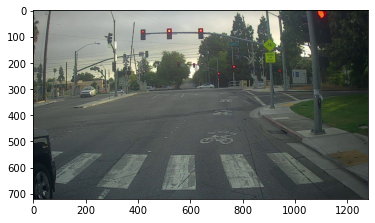

In [337]:
for i in range(0, 2):
    for y in range(0, 10):
        if y==0:
            for z in range(1, 10):
                out_scores, out_boxes, out_classes = predict(sess, "0%d%d%d.jpg"%(i,y,z))
        else:
            for z in range(0, 10):
                if ((i == 1) & (z == 1)) | (y>2):
                    break
                out_scores, out_boxes, out_classes = predict(sess, "0%d%d%d.jpg"%(i,y,z))

Found 7 boxes for test.jpg
car 0.60 (925, 285) (1045, 374)
car 0.66 (706, 279) (786, 350)
bus 0.67 (5, 266) (220, 407)
car 0.70 (947, 324) (1280, 705)
car 0.74 (159, 303) (346, 440)
car 0.80 (761, 282) (942, 412)
car 0.89 (367, 300) (745, 648)


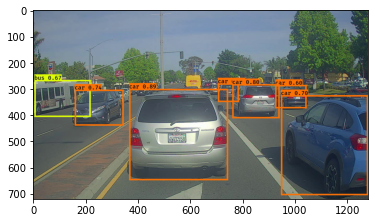

In [339]:
out_scores, out_boxes, out_classes = predict(sess, "test.jpg")

Found 0 boxes for 0001.jpg


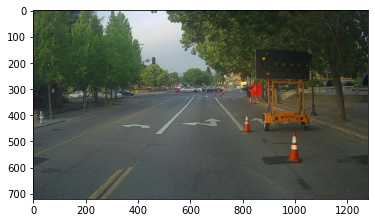

Found 0 boxes for 0002.jpg


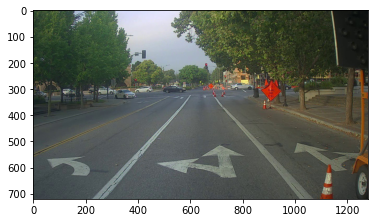

Found 3 boxes for 0003.jpg
car 0.69 (347, 289) (445, 321)
car 0.70 (230, 307) (317, 354)
car 0.73 (671, 284) (770, 315)


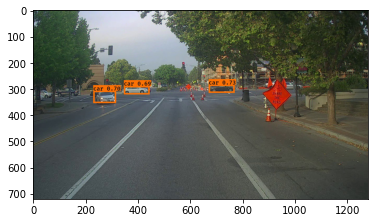

Found 4 boxes for 0004.jpg
car 0.63 (400, 285) (515, 327)
car 0.66 (95, 297) (227, 342)
car 0.68 (1, 321) (121, 410)
car 0.72 (539, 277) (658, 318)


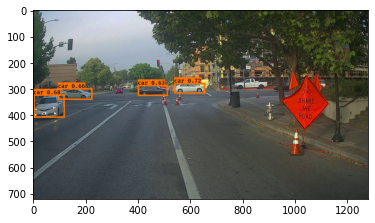

In [342]:
for i in range(1,5):
    predict(sess, "{:0>4}".format(i) + ".jpg")

### Summary

- YOLO runs an input image through a CNN which outputs a 19x19x5x85 dimensional volumne.
- The encoding can be seen as a grid where each of the 19x19 cells contains 5 anchor boxes.
- First we filter through all the boxes using non-max suppression. Specifically:
    - Score thresholding on the probability of detecting a class to keep only accurate (high probability) boxes
    - Intersection over Union (IoU) thresholding to eliminate overlapping boxes
- Because training a YOLO model from randomly initialized weights in non-trivial and requires a large dataset as well as lot of computation, we used previously trained model parameters in this project.
- We can also try fine-tuning the YOLO model with our own dataset, though this would be a fairly non-trivial exercise.

REFERENCES:
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 

**Car detection dataset**:
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The Drive.ai Sample Dataset</span> (provided by drive.ai) is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. We are especially grateful to Brody Huval, Chih Hu and Rahul Patel for collecting and providing this dataset. 